In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os
import numpy as np
from PIL import Image
import torchvision.models as models
import imageio
from tqdm import tqdm
# from torchsummary import summary
import matplotlib.pyplot as plt
from pytorch_pretrained_vit import ViT

In [2]:
class p1_data(Dataset):
    def __init__(self, path, transform=None):
        self.imgpaths = glob.glob(os.path.join(path,'*.jpg'))
        self.transform = transform
    def __getitem__(self, index) :
        img = Image.open(self.imgpaths[index]).convert('RGB')
        label = int(os.path.basename(self.imgpaths[index]).split('_')[0])
        if self.transform is not None:

            img = self.transform(img)
        return img, label
    def __len__(self):
        return len(self.imgpaths)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = ViT('B_16_imagenet1k', pretrained=True, num_classes=36).to(device)

cuda
Loaded pretrained weights.


In [4]:
from torchsummary import  summary
summary(model,(3,384,384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 24, 24]         590,592
PositionalEmbedding1D-2             [-1, 577, 768]               0
         LayerNorm-3             [-1, 577, 768]           1,536
            Linear-4             [-1, 577, 768]         590,592
            Linear-5             [-1, 577, 768]         590,592
            Linear-6             [-1, 577, 768]         590,592
           Dropout-7         [-1, 12, 577, 577]               0
MultiHeadedSelfAttention-8             [-1, 577, 768]               0
            Linear-9             [-1, 577, 768]         590,592
          Dropout-10             [-1, 577, 768]               0
        LayerNorm-11             [-1, 577, 768]           1,536
           Linear-12            [-1, 577, 3072]       2,362,368
           Linear-13             [-1, 577, 768]       2,360,064
PositionWiseFeedForward-14    

In [5]:
print(model)

ViT(
  (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (positional_embedding): PositionalEmbedding1D()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0): Block(
        (attn): MultiHeadedSelfAttention(
          (proj_q): Linear(in_features=768, out_features=768, bias=True)
          (proj_k): Linear(in_features=768, out_features=768, bias=True)
          (proj_v): Linear(in_features=768, out_features=768, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (pwff): PositionWiseFeedForward(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
      (1): Block(
 

In [ ]:
transform = transforms.Compose([
    transforms.Resize(model.image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ])

In [6]:
traindataset = p1_data('hw3_data/p1_data/train',transform=transform)
valdataset = p1_data('hw3_data/p1_data/val',transform=transform)
trainLoader = DataLoader(traindataset,batch_size=1)
valLoader = DataLoader(valdataset,batch_size=1)

In [7]:
def train(model, epoch, log_interval=100):
    # optimizer = optim.AdamW(params_to_update, lr=0.005)
    optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.5)
    criterion = nn.CrossEntropyLoss()
    correct = 0
    for ep in range(epoch):
        model.train()
        correct = 0
        train_loss = 0
        cnt = 0
        for data, target in tqdm(trainLoader):
            optimizer.zero_grad()
            data, target = data.to(device), target.to(device)
            output = model(data)
            # print(output.shape)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            train_loss += criterion(output, target).item()
            cnt+=1

        train_loss /= cnt
        print(f'Train Epoch: {ep+1}\tLoss: {train_loss:.6f}, Accuracy: {correct}/{len(trainLoader.dataset)} ({100. * correct / len(trainLoader.dataset):.0f}%)')

        val(model,ep) 
        scheduler.step()

In [8]:
def val(model,ep):
    criterion = nn.CrossEntropyLoss()
    model.eval() 
    val_loss = 0
    correct = 0
    with torch.no_grad(): # This will free the GPU memory used for back-prop
        for data, target in valLoader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(valLoader)
    print('\nVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(valLoader.dataset),
        100. * correct / len(valLoader.dataset)))

    if(100. * correct / len(valLoader.dataset)>90):
        torch.save(model, ('{}_{:.0f}.pth').format(ep,100. * correct / len(valLoader.dataset)))
    

In [9]:
model = torch.load('p1.pth').to(device)

In [160]:

def val_pos_emb(model):
    model.eval() 
    pos_emb = []
    with torch.no_grad(): # This will free the GPU memory used for back-prop
        zr = torch.zeros(1,3,384,384).to(device)
        # ↓↓↓↓hook↓↓↓↓
        def hook(module, input, output): 
            pos_emb.append(output[1].clone().detach())
        handle=model.positional_embedding.register_forward_hook(hook)
        output = model(zr)
        handle.remove()
    return pos_emb[0]
    

In [161]:
em_pos = val_pos_emb(model)
em_pos_ = em_pos[:,1:]

In [184]:
# reference : https://github.com/google-research/vision_transformer/issues/55

def patch_cosSim(pos_i, pos_j):
    cos = nn.CosineSimilarity(dim=0)
    s = em_pos_.shape
    # pos_patch = em_pos_.view(*s[1:])[:-1].view(24,24,-1)
    pos_patch = em_pos_.view(24,24,-1)
    n_rows = pos_patch.shape[0]
    n_cols = pos_patch.shape[1]
    patches = []
    for i in range(n_rows):
        for j in range(n_cols):
            patches.append(cos(pos_patch[pos_i][pos_j], pos_patch[i][j]).detach().cpu().numpy())
    return patches


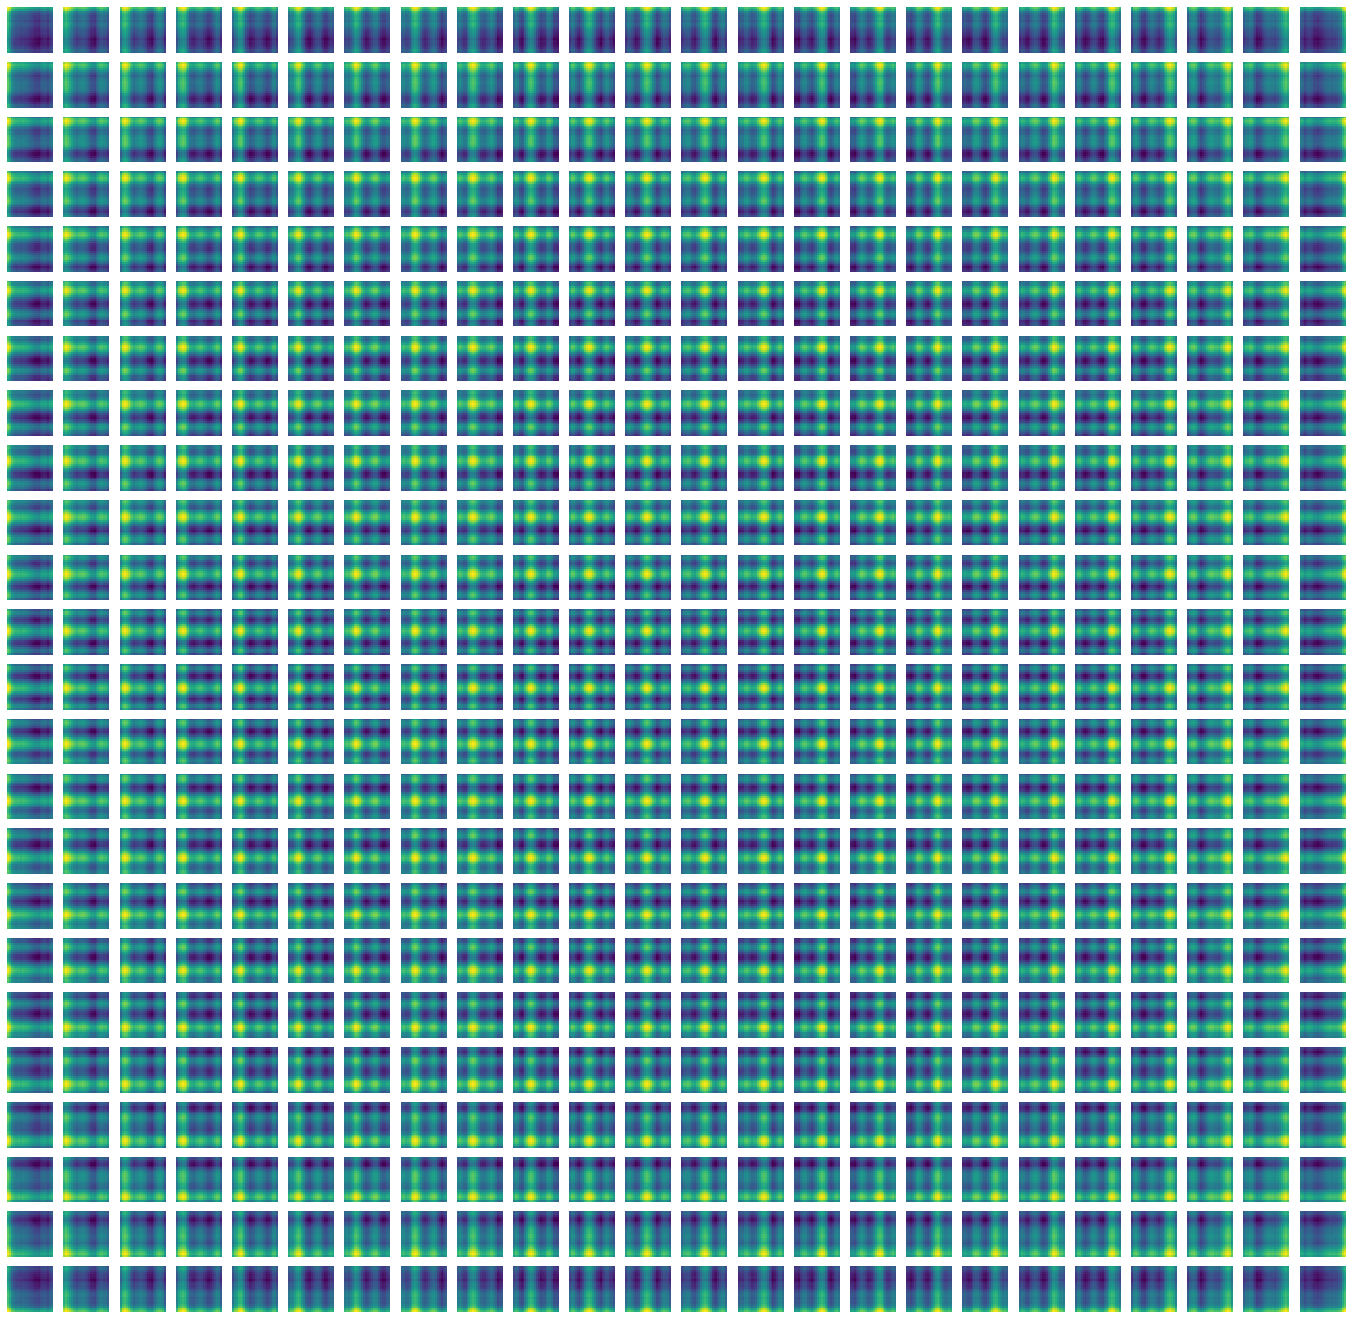

In [185]:
plt.figure(figsize=(24,24))
reg = 1
for i in range(24):
    for j in range(24):
        patch = patch_cosSim(i,j)
        plt.subplot(24,24,reg)
        plt.axis('off')
        plt.imshow(np.array(patch).reshape(24,24), interpolation='nearest')
        reg+=1
plt.show()

In [55]:
img1 = Image.open("hw3_data/p1_data/val/26_5064.jpg")
img2 = Image.open("hw3_data/p1_data/val/29_4718.jpg")
img3 = Image.open("hw3_data/p1_data/val/31_4838.jpg")

In [23]:
print(model.transformer.blocks[11].attn)

MultiHeadedSelfAttention(
  (proj_q): Linear(in_features=768, out_features=768, bias=True)
  (proj_k): Linear(in_features=768, out_features=768, bias=True)
  (proj_v): Linear(in_features=768, out_features=768, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
)


In [114]:
def val_att_map(model, img):
    model.eval() 
    att_map = []
    with torch.no_grad(): # This will free the GPU memory used for back-prop
        img = transform(img)
        img = img.unsqueeze(0).to(device)
        # ↓↓↓↓hook↓↓↓↓
        def hook(module, input, output): 
            att_map.append(output.clone().detach())
        
        handle=model.transformer.blocks[11].attn.register_forward_hook(hook)
        output = model(img)
        handle.remove()
        
    return att_map[0]
    

In [301]:
len(att_mat)

768

In [321]:
print(model.num_heads)

AttributeError: 'ViT' object has no attribute 'num_heads'

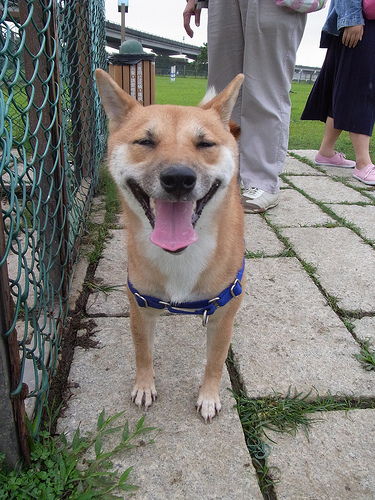

In [306]:
img3

In [307]:
attmap = val_att_map(model, img3)
logits, att_mat = attmap[:,:1], attmap[:,1:]
print(att_mat)
logits = logits.squeeze(0)
att_mat = att_mat.squeeze(0).transpose(1,0)
att = torch.matmul(logits, att_mat)/len(att_mat)

1
tensor([[[ 1.5893, -1.1807,  2.0227,  ..., -1.5468,  0.1904, -0.7898],
         [ 1.5159, -1.8833,  2.2465,  ..., -0.7488,  0.2098, -0.3784],
         [ 1.5812, -1.8303,  2.2760,  ..., -0.9657,  0.2447, -0.7217],
         ...,
         [ 0.7335,  0.0300,  0.3077,  ..., -0.1867,  0.5217,  0.7849],
         [ 1.3335, -0.5557,  1.2769,  ..., -0.8508,  0.2502, -0.5882],
         [ 1.0170,  0.1142,  0.7725,  ..., -0.6035,  0.1983, -0.4418]]],
       device='cuda:0')


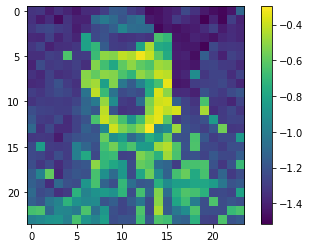

In [308]:
plt.figure()
# img_out1 = np.reshape(att_mat.detach().cpu().numpy(),(384,384,3))
plt.imshow(-np.reshape(att.detach().cpu().numpy(),(24,24)))
plt.colorbar()

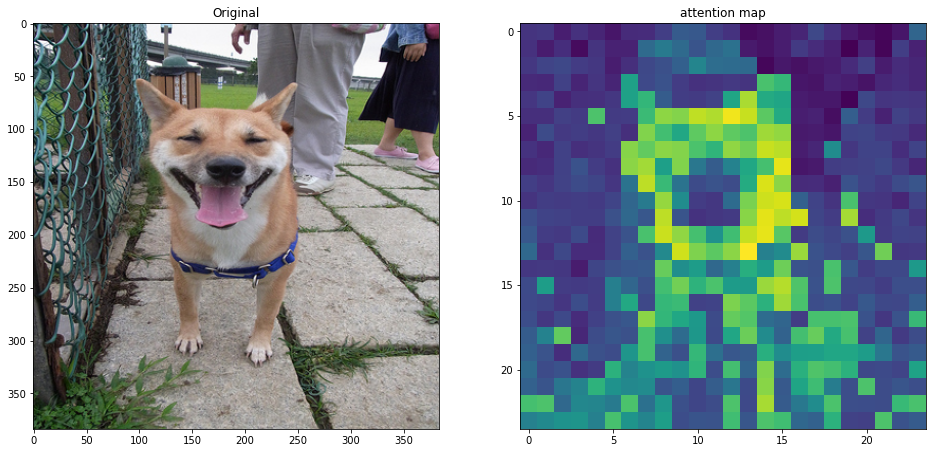

In [320]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
ax1.set_title('Original')
ax2.set_title('attention map')
# ax3.set_title('attention map with negative')
_ = ax1.imshow(img3.resize((384,384)))
_ = ax2.imshow(-np.reshape(att.detach().cpu().numpy(),(24,24)))
# _ = ax3.imshow(-np.reshape(att.detach().cpu().numpy(),(24,24)))

In [ ]:
def get_attention_map(img, get_mask=False):
    x = transform(img)
    x.size()

    logits, att_mat = model(x.unsqueeze(0))

    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    if get_mask:
        result = cv2.resize(mask / mask.max(), img.size)
    else:        
        mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
        result = (mask * img).astype("uint8")
    
    return result

def plot_attention_map(original_img, att_map):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map Last Layer')
    _ = ax1.imshow(original_img)
    _ = ax2.imshow(att_map)